# 章節 13：模擬

## 13.4 實作模擬情況

這裡是模擬的核心，請先從 MakeSequence 方法開始閱讀：

In [67]:
import math

# 計算在時間區間結束後，腫瘤的體積
def ExtendSequence(age, seq, rdt, interval):
    # age：在時間區間結束後，腫瘤的年齡
    # seq：是一個 tuple 包含到目前為止的體積
    # rdt：在這個時間區間的成長率（每年翻倍的比率 doubling per year）
    # interval：經過的時間區間（年）
    
    initial = seq[-1]
    doublings = rdt * interval
    final = initial * 2**doublings
    new_seq = seq + (final,)
    
    
    # Cache.Add 紀錄每個腫瘤在時間區間結束時的的年齡跟大小，下一小節會解釋 Cache 的機制
    # 在此先註解掉
    # cache.Add(age, new_seq, rdt)

    # final：時間區間結束後腫瘤的體積
    # new_seq：一個新的 tuple 除了舊的體積外還包含最後的體積 final
    return final, new_seq


# 將直徑轉（公分）成體積（立方公分）。這邊假設腫瘤是球體。
def Volume(diameter, factor=4*math.pi/3):
    # 球體體積公式
    return factor * (diameter/2.0)**3


def Diameter(volume, factor=4*math.pi/3):
    return 2*(volume/factor)**(1/3)


def MakeSequence(rdt_seq, v0=0.01, interval=0.67, vmax=Volume(20.0)):
    # rdt_seq：一個從生長率的 CDF 取樣的迭代器
    # v0：是初始體積（立方公分）
    # interval：時間區間（年）
    # vmax: 最大的直徑 20 公分
    
    seq = v0,
    age = 0
    for rdt in rdt_seq:
        age += interval
        final, seq = ExtendSequence(age, seq, rdt, interval)
        
        if final > vmax:
            break
        
    return seq

下方程式碼將 13.1 小節的 RDT 的兩個擬合的冪次分佈在此取樣，產生 rdt_seq。

最後調用上方的 MakeSequence 方法模擬腫瘤生長過程。

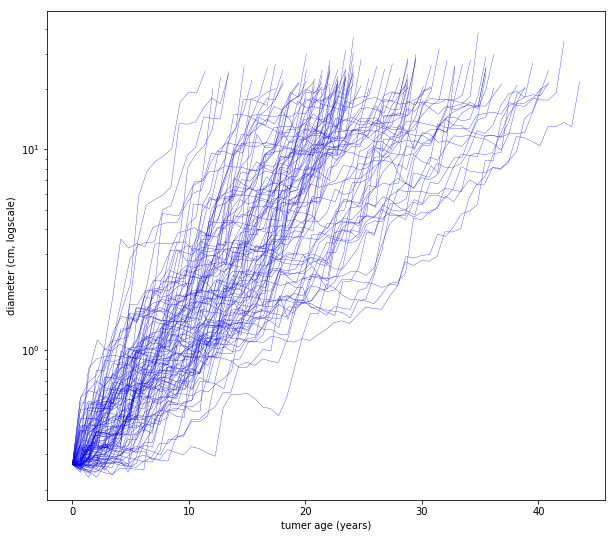

In [68]:
import thinkbayes as tb
import numpy as np
import matplotlib.pyplot as plt

def make_exp_pmf(low, high, lam, n=1000, frac=1.0):
    pmf = tb.Pmf()
    for i in np.linspace(low, high, n):
        pmf.Set(i, tb.EvalExponentialPdf(i, lam))
    
    pmf.Normalize(fraction=frac)
    return pmf


def make_rdt_seq(pmf_lower, pmf_higher):
    cdf_lower = pmf_lower.MakeCdf()
    cdf_higher = pmf_higher.MakeCdf()
    
    while True:
        if np.random.random() <= 0.35:
            yield cdf_lower.Sample(1)[0]
        else:
            yield cdf_higher.Sample(1)[0]
            
    

lam_lower = -5    
pmf_lower = make_exp_pmf(-2, 0, lam_lower, n=2000)

lam_higher = 0.79
pmf_higher = make_exp_pmf(0, 7, lam_higher, n=7000)

rdt_seq = make_rdt_seq(pmf_lower, pmf_higher)
plt.figure(figsize=(10,9))
for i in range(100):
    # 將體積轉乘半徑的比例
    y = [Diameter(volume) for volume in MakeSequence(rdt_seq)]
    
    x = np.linspace(0, len(y)*0.67, len(y))
    plt.yscale("log")
    plt.plot(x, y, c='b', linewidth=0.3)
    
plt.xlabel("tumer age (years)")
plt.ylabel("diameter (cm, logscale)")
plt.show()

上圖為模擬 100 次的的結果。快一點大約 8 年就超過直徑 10 公分，慢一點到 37 年才超過直徑 10 公分。（模擬結果與原書不同，但是觀點是一樣的）

縱軸是將體積轉換成直徑，並且用對數空間呈現。